In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from grblas import Matrix, Vector
from grblas import descriptor
from grblas import UnaryOp, BinaryOp, Monoid, Semiring

In [2]:
def vrepr(v):
    df = pd.DataFrame(index=range(v.size), columns=[''])
    for i, val in zip(*v.to_values()):
        df.iloc[i] = val
    return df.where(pd.notnull(df), '')

def hrepr(v):
    return vrepr(v).T

def mrepr(m):
    df = pd.DataFrame(columns=range(m.ncols), index=range(m.nrows))
    for i, j, val in zip(*m.to_values()):
        df.iloc[i, j] = val
    return df.where(pd.notnull(df), '')

def draw(m):
    g = nx.DiGraph()
    for row, col, val in zip(*m.to_values()):
        g.add_edge(row, col, weight=val)
    pos = nx.spring_layout(g)
    edge_labels = {(i, j): d['weight'] for i, j, d in g.edges(data=True)}
    nx.draw_networkx(g, pos, node_color='red', node_size=500)
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)

## Create and visualize a Matrix

In [3]:
data = [
    [3,0,3,5,6,0,6,1,6,2,4,1],
    [0,1,2,2,2,3,3,4,4,5,5,6],
    [3,2,3,1,5,3,7,8,3,1,7,4]
]

In [4]:
rows, cols, weights = data
m = Matrix.new_from_values(rows, cols, weights)
m
# Size of the sparse matrix is 7x7 with 12 non-zero elements of type INT64

<Matrix 12/(7x7):INT64>

In [5]:
mrepr(m)
# This is an adjacency matrix
# Reading along a row shows the out-nodes of a vertex
# Reading along a column shows the in-nodes of a vertex

,0,1,2,3,4,5,6
0,,2,,3,,,
1,,,,,8,,4
2,,,,,,1,
3,3,,3,,,,
4,,,,,,7,
5,,,1,,,,
6,,,5,7,3,,


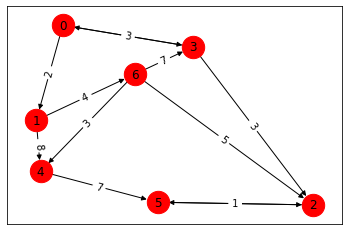

In [6]:
draw(m)

## Create and visualize a Vector

In [7]:
v = Vector.new_from_type(m.dtype, m.nrows)
v.element[1] = 0

In [8]:
hrepr(v)

,0,1,2,3,4,5,6
,,0,,,,,


In [9]:
vrepr(v)

,
0,
1,0
2,
3,
4,
5,
6,


## Single-source Shortest Path

This uses the **_min-plus_** semiring because we want to add the edges, then take the minimum length of available paths.

In [10]:
# Create a vector and initialize a starting vertex (1) with a distance of zero
v = Vector.new_from_type(m.dtype, m.nrows)
v.element[1] = 0
hrepr(v)

,0,1,2,3,4,5,6
,,0,,,,,


In [11]:
mrepr(m)

,0,1,2,3,4,5,6
0,,2,,3,,,
1,,,,,8,,4
2,,,,,,1,
3,3,,3,,,,
4,,,,,,7,
5,,,1,,,,
6,,,5,7,3,,


In [12]:
# v @ m will give us one step in a Breadth-first search
w = Vector.new_from_existing(v)
w.assign[:] = 1
w[:] = v.vxm(m, Semiring.MIN_PLUS)
hrepr(w)

,0,1,2,3,4,5,6
,,,,,8,,4


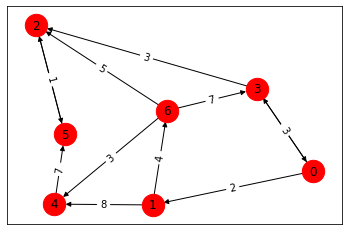

In [13]:
# Look again at m and see that vertex 1 points to vertices 4 and 6 with the weights indicated
draw(m)

We have the right semiring, but we already lost the initial distance=0 for vertex 1. How do we keep that information around as we step thru the BFS?

GraphBLAS has a builtin accumulator available for every operation.
Because it's C-based, you pass in the output object and it accumulates its existing values with the result, then returns itself.

In [14]:
w = Vector.new_from_existing(v)
w[BinaryOp.MIN] = v.vxm(m, Semiring.MIN_PLUS)
hrepr(w)
# Now we see that the zero distance for vertex 1 is preserved

,0,1,2,3,4,5,6
,,0,,,8,,4


Let's take another step

In [15]:
w[BinaryOp.MIN] = w.vxm(m, Semiring.MIN_PLUS)
hrepr(w)
# We see that the path to vertex 4 is now shorter. That's `min` doing its thing.
# Verify the other path distances from vertex 1 with at most two hops

,0,1,2,3,4,5,6
,,0,9,11,7,15,4


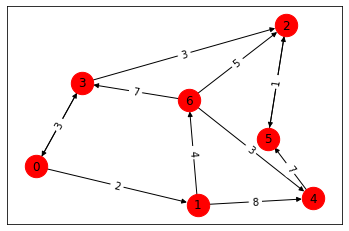

In [16]:
draw(m)

The algorithm repeats until a new computation is the same as the previous result

In [17]:
w = Vector.new_from_existing(v)
while True:
    w_old = Vector.new_from_existing(w)
    w[BinaryOp.MIN] = w.vxm(m, Semiring.MIN_PLUS)
    if w == w_old:
        break
hrepr(w)

,0,1,2,3,4,5,6
,14,0,9,11,7,10,4


## Alternate solution without using accumulator

In the min_plus semiring, the "empty" value of a sparse matrix is not actually 0, but +infinity.

That way, `min(anything, +inf) = anything`, similar to the normal addition 0 of `add(anything, 0) = anything`.

A clever trick sets the diagonal of the matrix to all zeros. This makes it behave like the Identity matrix for the min_plus semiring.

Observe:

In [18]:
m_ident = Matrix.new_from_values(range(7), range(7), [0]*7)
mrepr(m_ident)

,0,1,2,3,4,5,6
0,0,,,,,,
1,,0,,,,,
2,,,0,,,,
3,,,,0,,,
4,,,,,0,,
5,,,,,,0,
6,,,,,,,0


In [19]:
v.rebuild_from_values([1], [0])
hrepr(v)

,0,1,2,3,4,5,6
,,0,,,,,


In [20]:
v[:] = v.vxm(m_ident, Semiring.MIN_PLUS)
hrepr(v)
# See how it preserved v exactly

,0,1,2,3,4,5,6
,,0,,,,,


In [21]:
# Let's try again
v.rebuild_from_values([0, 1, 4], [14, 0, 77])
v[:] = v.vxm(m_ident, Semiring.MIN_PLUS)
hrepr(v)

,0,1,2,3,4,5,6
,14,0,,,77,,


So zeros along the diagonal preserve what you already have in `v` without adding any new path information. That's the behavior we want, so let's update `m` with zeros on the diagonal and repeat SSSP without using accumulators.

In [22]:
for i in range(m.nrows):
    m.element[i, i] = 0
mrepr(m)

,0,1,2,3,4,5,6
0,0,2,,3,,,
1,,0,,,8,,4
2,,,0,,,1,
3,3,,3,0,,,
4,,,,,0,7,
5,,,1,,,0,
6,,,5,7,3,,0


In [23]:
# Reset v
v.clear()
v.element[1] = 0
hrepr(v)

,0,1,2,3,4,5,6
,,0,,,,,


In [24]:
# Take one step (notice no accumulator is specified)
v[:] = v.vxm(m, Semiring.MIN_PLUS)
hrepr(v)

,0,1,2,3,4,5,6
,,0,,,8,,4


In [25]:
# Repeat until we're converged
while True:
    w = Vector.new_from_existing(v)
    v[:] = v.vxm(m, Semiring.MIN_PLUS)
    if v == w:
        break
hrepr(v)

,0,1,2,3,4,5,6
,14,0,9,11,7,10,4


### And that's SSSP in 5 very readable lines of Python, thanks to GraphBLAS